In [33]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
#import tensorflow as tf
import torch.optim as optim
import torch.nn.functional as F
import base64, io
import random
import pickle
from math import e

if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"

print(device, " in use")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

cuda  in use


/tmp/ipykernel_996/287576977.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Agent

In [34]:
## Agent 
class RandomAgent:
  def __init__(self, env, epsilon, epsilon_decay):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_array = list()
    self.epsilon_min = 0.35
    self.epsilon_max = epsilon

  def step(self, obs, policy, Q):
    self.epsilon = max ( self.epsilon * self.epsilon_decay , self.epsilon_min)
    self.epsilon_array.append(self.epsilon)

    if policy == "e-greedy":
      if np.random.uniform() > self.epsilon:
        return np.argmax(Q)
      else:
        return np.random.choice(self.action_space.n)

    elif policy == "random":
      return np.random.choice(self.action_space.n)

    elif policy == "optimal":
      return np.argmax(Q)
  
  def give_epsilon_history(self):
    return self.epsilon_array
  
  def reset(self):
    self.epsilon = self.epsilon_max

## DQN Network

In [35]:
### Paramters
epsilon = 0.9
gamma = 0.99
epsilon_decay = 0.99

## Environment Initialisation
env = gym.make('LunarLander-v2')
agent = RandomAgent(env, epsilon, epsilon_decay)

observation, info = env.reset()
terminated, truncated = False, False

# BEGIN_YOUR_CODE
observation = np.array([observation], dtype='float32')

# Define Action Value model
class DQN_AV(nn.Module):
    def __init__(self):
        super(DQN_AV, self).__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
        self.layer1 = nn.Linear(8, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, x):
        #out = self.network_arch(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)
        #return out

AV = DQN_AV().to(device)
#print(model)


# Define Target Action model
class DQN_TA(nn.Module):
    def __init__(self):
        super(DQN_TA, self).__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
        self.layer1 = nn.Linear(8, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 4)

    def forward(self, x):
        #out = self.network_arch(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)
        #return out

TA = DQN_TA().to(device)
#print(model)

TA.load_state_dict(AV.state_dict())

input = torch.from_numpy(observation)
print("Observation : " , observation)
out = AV(input.to(device))
print("Q Values from Action Value : ", out.to("cpu").detach().numpy())
out = TA(input.to(device))
print("Q Values from Target Action : ", out.to("cpu").detach().numpy())

Observation :  [[ 0.00589666  1.4166145   0.5972486   0.25307128 -0.00682594 -0.1352858
   0.          0.        ]]
Q Values from Action Value :  [[-0.01068235  0.07528687 -0.03097387  0.03978832]]
Q Values from Target Action :  [[-0.01068235  0.07528687 -0.03097387  0.03978832]]


## Hyperparameters

In [36]:
### Paramters
epsilon = 0.9
gamma = 0.99
epsilon_decay = 0.999

policy = "e-greedy"

D = list()

Cum_reward_arr = list()
no_of_timestep = list()

## Environment Initialisation
env = gym.make('LunarLander-v2')
agent = RandomAgent(env, epsilon, epsilon_decay)

## Reset
obs, info = env.reset()
agent.reset()
terminated, truncated = False, False


## Parameters
miniBatch = 32
C = 100
episodes = 20
M = 400
learning_rate = 0.001

optimizer = optim.AdamW(AV.parameters(), lr= learning_rate)
# , amsgrad=True
## Update Q
#Q = update_Q_AV(env, Q)
#QT = update_Q_TA(env, QT)

## Training

In [37]:
x = 0
# Compute MSE loss
criterion = nn.MSELoss() #nn.SmoothL1Loss()

for m in range(M):

  ## Store Replay Memory
  x = len(Cum_reward_arr)
  D = list()
  for episode in range(episodes):
    itr = 0
    total_reward = 0
    with torch.no_grad():
      while not terminated:
        itr = itr +1
        Q = AV(torch.tensor(obs, dtype=torch.float).to(device))
        ## Take Action
        action = agent.step(obs, policy, list( Q.to("cpu").numpy() ))
        
        ## Observe reward and state
        new_obs, reward, terminated, truncated, info = env.step(action)

        ## Store in D 
        D.append([obs, action , reward, new_obs, terminated])

        ## Update State
        obs = new_obs
        
        ## Cumulative reward
        total_reward += reward
                
        if(truncated):
            #print("Terminal State: ", episode, " : ", itr, " steps" )
            #no_of_timestep.append(itr)
            break

      no_of_timestep.append(itr)
      
      obs, info = env.reset()
      terminated, truncated = False, False
      Cum_reward_arr.append(total_reward)
  #print(totol_loop)
  ## Optimise model
  totol_loop = len(D)//miniBatch
  #print(totol_loop)
  agent.reset()
  for k in range(totol_loop):
    ## Sample random from miniBatch
    err = 0
    state_arr = list()
    action_arr = list()
    reward_arr = list()
    exp = list()


    # For One miniBatch
    for i in range(miniBatch):
      idx = random.randint(1, len(D) -1)
      st, a, r, st1, terminated = D[idx]

      state_arr.append(st)
      action_arr.append(a)
      #reward_arr.append(r)

      if terminated:
        y = r
      else:
        with torch.no_grad():
          Q = AV(torch.tensor(st1, dtype=torch.float).to(device))
          QT = TA(torch.tensor(st1, dtype=torch.float).to(device))
        y = r + gamma*QT[np.argmax(Q.to("cpu").numpy())]

      exp.append(y)

    state_arr = torch.tensor(state_arr, dtype=torch.float).to(device)
    action_arr = torch.tensor(action_arr, dtype=torch.int64).to(device)
    #reward_arr = torch.tensor(reward_arr, dtype=torch.float)

    #state_arr = state_arr.view(32)
    action_arr = action_arr.view(32, 1)

    #print(state_arr.shape)
    #print(action_arr.shape)

    state_action_values = AV(state_arr).gather(1, action_arr)
    expected_state_action_values = torch.tensor(exp, dtype=torch.float).to(device)

    ## Gradient descent on Q
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    #torch.nn.utils.clip_grad_value_(AV.parameters(), 100)
    optimizer.step()

    ## Update after Every C step
    if k%C == 0:
      TA.load_state_dict(AV.state_dict())
      # print("Updated")


  plt.plot(Cum_reward_arr)
  plt.pause(0.001)

  display.display(plt.gcf())
  display.clear_output(wait=True)

  #print(" Average score is " , sum(Cum_reward_arr[x:])/len(Cum_reward_arr[x:]) , " No of iterations : " , sum(no_of_timestep[x:])/len(no_of_timestep[x:]) )

<Figure size 800x550 with 0 Axes>

## Save Q Table

In [44]:
#@title Save Q Table
import pickle

PATH = "lunar_DDQN.pth"
torch.save(AV.state_dict(), PATH)

weights = AV.state_dict()
with open('LunarLandar_weights_DDQN.pkl', 'wb') as f:
    pickle.dump(weights, f)

## Load Q table

In [90]:
PATH = "lunar_good.pth"
AV.load_state_dict(torch.load(PATH))

<All keys matched successfully>

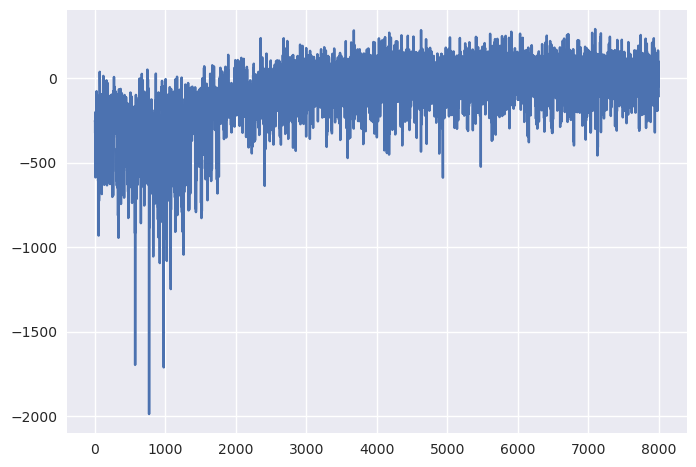

In [38]:
plt.plot(Cum_reward_arr)

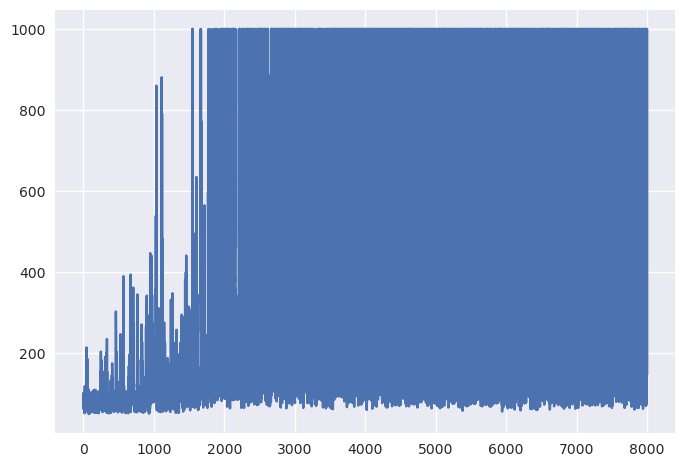

In [39]:
plt.plot(no_of_timestep)

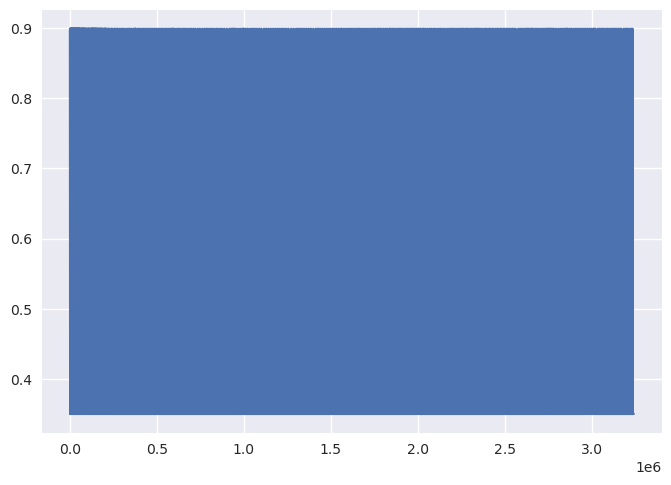

In [41]:
arr = agent.give_epsilon_history()
plt.plot(arr)

## Evaluation

In [45]:
agent = RandomAgent(env, epsilon, epsilon_decay)
env = gym.make('LunarLander-v2')#, render_mode="human")
reward_arr = list()
itr_arr = list()
policy = "optimal"

visualise = False

for episode in range(100):
  terminated, truncated = False, False
  obs, info = env.reset()
  reward_cum = 0
  itr = 0
  with torch.no_grad():
    while not terminated :
      itr += 1
      Q = AV(torch.tensor(obs, dtype=torch.float).to(device))
      action = agent.step(obs, policy, list( Q.to("cpu").numpy() ))
      obs, reward, terminated, truncated, info = env.step(action)
      env.render()
      reward_cum += reward

      if(truncated):
        #print("You Won")
        break

    obs, info = env.reset()
    terminated, truncated = False, False
    reward_arr.append(reward_cum)
    visualise = False
    itr_arr.append(itr)

env.close()

/home/hri/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/box2d/lunar_lander.py:616: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


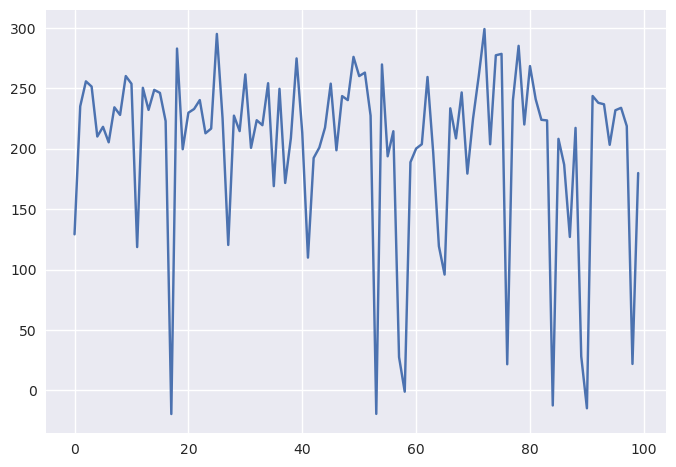

In [46]:
plt.plot(reward_arr)

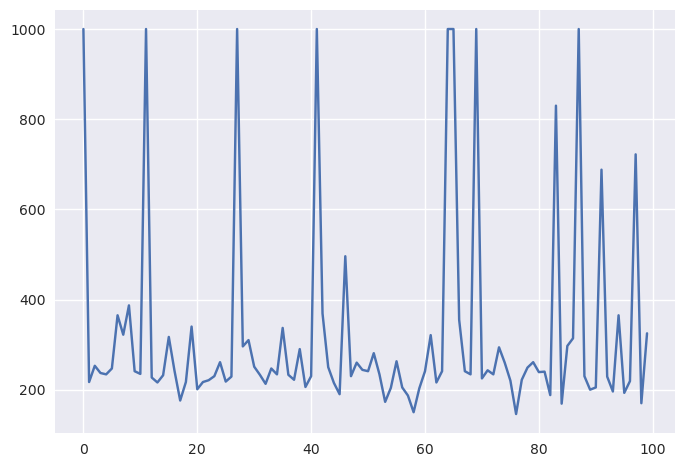

In [47]:
plt.plot(itr_arr)